# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [3]:
URL = "https://www.indeed.com/jobs?q=data+scientist+salary&l=New+York"

In [774]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections as coll
import patsy
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [7]:
## YOUR CODE HERE
response = requests.get(URL)
html = response.text
soup = BeautifulSoup(html, 'html.parser', from_encoding="utf-8")

In [366]:
rowresult = soup.find_all("div", {"class": " row result"})[0]

In [368]:
print rowresult.prettify()

<div class=" row result" data-jk="399d4d7396ea2dd1" data-tn-component="organicJob" id="p_399d4d7396ea2dd1" itemscope="" itemtype="http://schema.org/JobPosting">
 <h2 class="jobtitle" id="jl_399d4d7396ea2dd1">
  <a class="turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=399d4d7396ea2dd1&amp;fccid=21e3d13217a9af99" itemprop="title" onclick="setRefineByCookie([]); return rclk(this,jobmap[0],true,0);" onmousedown="return rclk(this,jobmap[0],0);" rel="nofollow" target="_blank" title="Data Analytics Engineer">
   <b>
    Data
   </b>
   Analytics Engineer
  </a>
 </h2>
 <span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
  <span itemprop="name">
   Fractal Industries
  </span>
 </span>
 -
 <span itemprop="jobLocation" itemscope="" itemtype="http://schema.org/Place">
  <span class="location" itemprop="address" itemscope="" itemtype="http://schema.org/Postaladdress">
   <span itemprop="addressLocality">
    New York, NY
   </span>
  </span>


Looking at the result above, we can see that there is some structure:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [60]:
## YOUR CODE HERE
def get_co(cos):
    company = ""
    for entry in cos:
        if entry != ("" or None):
            try:
                company = str(entry.find("a").text).lstrip()
            except:
                company = "No Company Listed"
        else:
            company = "No Company Listed"
    return company

In [21]:
get_co(soup.find_all("span", {"class": "company"}))

'Bank of America'

In [22]:
def get_salary(salaries):
    for entry in salaries:
        if entry != ("" or None):
            try:
                salary = str(entry.find("nobr").text)
            except:
                salary = "No Salary Listed"
        else:
            salary = "No Salary Listed"
    return salary

In [23]:
get_salary(soup.find_all("td",{"class":"snip"}))

'No Salary Listed'

In [24]:
def get_jobtitle(titles):
    for entry in titles:
        if entry != ("" or None):
            try:
                jobtitle = str(entry.text)
            except:
                jobtitle = "No Job Title Listed"
        else:
            jobtitle = "No Job Title Listed"
    return jobtitle

In [25]:
get_jobtitle(soup.find_all("a", {"class":"turnstileLink"}))

'Quantitative Finance Analyst'

In [26]:
def get_location(locations):
    for entry in locations:
        if entry != ("" or None):
            try:
                location = str(entry.text)
            except:
                location = "No Location Listed"
        else:
            location = "No Location Listed"
    return location

In [27]:
get_location(soup.find_all("span", {"class":"location"}))

'New York, NY 10036'

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [28]:
YOUR_CITY = 'Raleigh'

In [204]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 2000 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
        for start in range(0, max_results_per_city, 10):
            url = "http://www.indeed.com/jobs?q=data+scientist+%24220000&l="+str(city)+"&start="+str(start)
            response = requests.get(url)
            html = response.text
            results.append(html)
        # Grab the results from the request (as above)
        # Append to the full set of results
        pass

We need to separate into bin due to the way that Indeed operates, if salary information is not available for the position, Indeed will provide estimates and include or get rid of those job profiles from the search results based on the salary you provide in the search query.

Looking at the distributions of salaries across the cities that we have chosen, I have chosen Raleigh, North Carolina as my city, as it is one of the data science hubs in the US, and as per Indeed's data scientist descriptions seems to have the highest salary listed.

As a look at the Indeed jobs listing, most of the salary information is missing so we have to impute the value based on the search query and we will use the search query results to separate into bins and then adjust the dataset accordingly, as Indeed uses 10 bins to display their salary ranges for each city in their descriptions for each, I will try to follow a similar model and try to induce and impute the missing salary information accordingly.

The lowest salary we have is 29,000 so I will start my bin scrapes around 20,000 and go up by 40,000 in each bin till about 200000.

1. 20,000 - 60,000
2. 60,000 - 100,000
3. 100,000 - 140,000
4. 140,000 - 180,000
5. 180,000 - 220,000
6. 220,000 + 

We will have to scrape the data multiple times with our salary bins and then remove the duplicates from the field so we can impute the missing salary data. The link is structured in a way that we can fill the salary with a number and we will get all salaries above this number.

"https://www.indeed.com/jobs?q=data+scientist+%24" + salary + &l=Raleigh%2C+NC

We will scrape with a value of 2000 max results per city.

In [207]:
r_20 = ''.join(results) #Rerunning for each scrape.

In [208]:
soup_20 = BeautifulSoup(r_20, 'html.parser', from_encoding="utf-8") #Reran this with each different 

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [210]:
#Create a new dataframe for each of the dataframes that we will be merging together.
ds20 = pd.DataFrame(columns=["location","title","company","salary"]) 
ds60 = pd.DataFrame(columns=["location","title","company","salary"])
ds100 = pd.DataFrame(columns=["location","title","company","salary"])
ds140 = pd.DataFrame(columns=["location","title","company","salary"])
ds180 = pd.DataFrame(columns=["location","title","company","salary"])
ds220 = pd.DataFrame(columns=["location","title","company","salary"])

In [230]:
for row in soup_20.find_all("div", {"class": " row result"}): #Searches through each of the row results.
    loc = get_location(row.find_all("span", {"class":"location"}))
    jt = get_jobtitle(row.find_all("a", {"class":"turnstileLink"}))
    co = get_co(row.find_all("span", {"class": "company"}))
    sal = get_salary(row.find_all("td",{"class":"snip"}))
    ds20.loc[len(ds20)]=[loc, jt, co, sal] #Make a new record in the above created dataframes with the results parsed.

In [6]:
dfs = [ds20, ds60, ds100, ds140, ds180, ds220] #Create a list of the dataframes

Creating a save point to ensure our data is backed up in case any of our dataframes become corrupted.

In [259]:
counter = 0
for x in dfs:
    x.to_csv(str(counter)+'.csv')
    counter += 1

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

We will create a new column for the salary ranges from the filter searches that we made, called salrange and we will use the lower bracket of the value that we will use to impute the missing values after getting rid of duplicated records and then merging the dataframes.

In [282]:
ds20['salrange'] = 20000
ds60['salrange'] = 60000
ds100['salrange'] = 100000
ds140['salrange'] = 140000
ds180['salrange'] = 180000
ds220['salrange'] = 220000

After creating a new column for our dataframes, we are going to check whether we have any missing values.

In [357]:
for x in dfs:
    print x.isnull().sum().sort_values(ascending=False)[0:2]

salrange    0
salary      0
dtype: int64
salrange    0
salary      0
dtype: int64
salrange    0
salary      0
dtype: int64
salrange    0
salary      0
dtype: int64
salrange    0
salary      0
dtype: int64
salrange    0
salary      0
dtype: int64


Let's check the shapes of our dataframes:

In [314]:
for x in dfs:
    print x.shape

(5474, 5)
(4630, 5)
(2800, 5)
(515, 5)
(38, 5)
(8, 5)


Let's create a new dataframe concatenated with all dataframes before removing duplicates and check the shape:

In [7]:
df = pd.concat(dfs)

In [1662]:
df.shape

(13465, 5)

Remove any records which are duplicated over the four features - Location, Title, Salary and Company:

In [1663]:
df.drop_duplicates(['location','salary','company', 'title'], keep='last', inplace=True)

Keep = 'last' was used to ensure that the value with the upper bound in salary range was kept rather than the lower bound for any duplicates.

In [1664]:
df.shape

(6358, 5)

Removing the records that had all four features in common, we reduced our dataframe to half to 6358 jobs.

In [1665]:
df.reset_index(drop=True, inplace=True) #Reset the index for usability.

I checked the value counts by salary range to ensure that our distribution of jobs by salary range seems to match that from Indeed and matches the number of jobs we scraped in each data frame and also checked for any missing values:

In [1666]:
df.salrange.value_counts()

60000     2363
100000    2051
20000     1445
140000     461
180000      30
220000       8
Name: salrange, dtype: int64

In [1667]:
df.isnull().sum().sort_values(ascending=False)[0:2]

salrange    0
salary      0
dtype: int64

Drop all records that are weekly or hourly as they do will not be useful to us.

In [1668]:
df = df[~df.salary.str.contains("hour")]
df = df[~df.salary.str.contains("week")]

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

Let's clean the column first and remove any commas and dollar signs:

In [1669]:
df['salary'] = df['salary'].str.replace("$","")
df['salary'] = df['salary'].str.replace(",","")

Looking at salaries that aren't missing:

In [1670]:
df.loc[df['salary'] != 'No Salary Listed', 'salary'].head(20).tolist()

['43794 a year',
 '46831 a year',
 '39983 - 55500 a year',
 '50000 - 55000 a year',
 '50000 - 61500 a year',
 '49000 - 61000 a year',
 '33840 - 40000 a year',
 '30000 - 45000 a year',
 '33000 - 42000 a year',
 '60000 - 80000 a year',
 '70000 - 110000 a year',
 '120000 - 150000 a year',
 '90000 a year',
 '85000 a year',
 '47484 a year',
 '52000 a year',
 '140000 - 170000 a year',
 '140000 a year',
 '58945 - 158270 a year',
 '3987 a month']

After cleaning, we find that there are 2 variations of strings at the end of each of the salary information, a month and a year.

Using the regex pattern: r'[w\]+' we will match unicode word characters # same as [a-zA-Z0-9] which will be useful in matching the patterns in our salary string

In [1671]:
pattern = r'[\w]+'
test_string = '58945 - 158270 a year'
mtch = re.findall(pattern, test_string)
print mtch[0], mtch[1], mtch[2], mtch[3]

58945 158270 a year


The regex breaks down the salary string into its components without the hyphen and as such we can pull the numeric values out of a range with mtch[0] and mtch[1], and only use mtch[0] where the length of the regex match is less than 3. We can also use the last element of the regex to check whether the salary string is for a month or year.

In [1672]:
def salary_clean(string):
    if string != "No Salary Listed":
        pattern = r'[\w]+'
        mtch = re.findall(pattern, string)
        lenchk = len(mtch) > 3
        if mtch[-1] == 'year':
            if lenchk:
                string = (int(mtch[0])+int(mtch[1]))/2
            else:
                string = int(mtch[0])
        elif mtch[-1] == 'month':
            if lenchk:
                string = (int(mtch[0])+int(mtch[1])/2)*12
            else:
                string = int(mtch[0])*12
    return string

In [1673]:
df.salary = df.salary.apply(salary_clean)

In [1674]:
df.salary.value_counts()[0:5]

No Salary Listed    5896
150000                16
100000                13
160000                12
120000                12
Name: salary, dtype: int64

In [1675]:
df.loc[df['salary'] != 'No Salary Listed'].sample(5)

,location,title,company,salary,salrange
5984,"San Francisco, CA",Lead Data Scientist (Life Sciences Opportunity),Workbridge Associates,150000,140000
4441,"San Francisco, CA",Digital Marketing (Data Scientist),No Company Listed,115000,100000
4992,"New York, NY",EpicCare Ambulatory Analyst: Research-Registry...,No Company Listed,112500,100000
4556,"San Francisco, CA 94105 (Financial District area)","Full Stack Engineer, Series B Company",Workbridge Associates,120000,100000
1523,"Goodyear, AZ",Budget & Research Analyst,No Company Listed,79126,60000


In [1676]:
df.reset_index(drop=True, inplace=True)

Taking a look at our df.tail() we find that the salary range field that we created based on Indeed's search algorithm does correspond correctly to those we have data for.

Finally we need to clean our location field to get the city as that's the only thing we will be using.

In [1677]:
loc = [df.location[i].split(",") for i in range(len(df.location))] #Create list of our loc string split by ,

In [1678]:
df['state'] = [loc[row][1][1:3] for row in range(len(loc))] #References the loc list and selects the state.
df['city'] = [loc[i][0] for i in range(len(df.location))] #Create a new dataframe with cities from our split

Indeed had parsed more cities than I inputted originally, as such I will create a new 'state' column and keep these cities in rather than dropping the rows, so we can see the difference that state has as well as city.

In [1679]:
df.state.value_counts()

CA    1821
NY    1082
WA     595
TX     519
PA     500
IL     460
CO     319
GA     257
NC     218
NJ     192
FL     121
AZ      91
OR      77
DE      34
Name: state, dtype: int64

We now have the 14 states that our cities we chose originally from. One more check for null values:

In [1680]:
df.isnull().sum()

location    0
title       0
company     0
salary      0
salrange    0
state       0
city        0
dtype: int64

### Save your results as a CSV

In [1681]:
df.to_csv('./indeed_salaries.csv')

In [663]:
f = './indeed_salaries.csv'
df = pd.read_csv(f)

In [664]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [665]:
df.loc[df['salary'] != "No Salary Listed", 'salary'] = df.loc[df['salary'] != "No Salary Listed", 'salary'].astype(int)

## Predicting salaries using Logistic Regression

We will first take a look a the results that we have first which do have salary information.

In [666]:
df.loc[df.salary != "No Salary Listed"].sample(5) #Selecting a sample all from our df that have salary information.

,location,title,company,salary,salrange,state,city
6120,"New York, NY 10001 (Chelsea area)",Associate Director Translational Science/Bioma...,Skills Alliance,175000,140000,NY,New York
6268,"New York, NY",Data Scientist (People Analytics/HR),No Company Listed,215000,180000,NY,New York
4899,"New York, NY 10038 (Financial District area)",Data Scientist,No Company Listed,130000,100000,NY,New York
1674,"Chicago, IL",Senior Quantitative Analyst,No Company Listed,65000,60000,IL,Chicago
4588,"New York, NY",Health Scientist,Centers for Disease Control and Prevention,117437,100000,NY,New York


Let's look at how many records we have with salary information:

In [667]:
df.loc[df.salary != "No Salary Listed"].shape #We have 390 records with salary information.

(390, 7)

In [668]:
print "The median salary is $",np.median(df.loc[df.salary != "No Salary Listed", 'salary'])
print "The mean salary is $", round(np.mean(df.loc[df.salary != "No Salary Listed", 'salary']),2)

The median salary is $ 104624.0
The mean salary is $ 111785.72


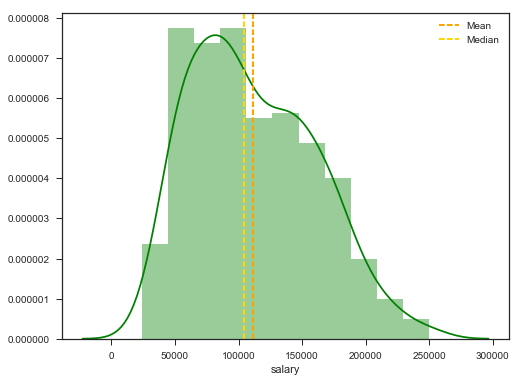

In [669]:
sns.set_style(style='ticks', rc=None)
fig = plt.figure(figsize=(8,6))
sns.distplot(df.loc[df.salary != "No Salary Listed", 'salary'], kde=True, color='green')
plt.axvline(round(np.mean(df.loc[df.salary != "No Salary Listed", 'salary']),2), color='orange', label="Mean", linestyle='dashed', linewidth=2)
plt.axvline(np.median(df.loc[df.salary != "No Salary Listed", 'salary']), color='gold', label="Median", linestyle='dashed', linewidth=2)
plt.legend();


This seems to resemble the distribution of salaries we saw from Indeed's own distributions listed from above.

The mean salary is quite a bit higher than the median salary which means there's some higher paying jobs that is pulling the tail right.

We will first create a dataframe with only our salary information listed and use a logistic regression on that and test our model against that after with our salary range informaton.

In [670]:
dfm = df.loc[df.salary != "No Salary Listed"]

In [671]:
dfm.sample(10)

,location,title,company,salary,salrange,state,city
1316,"Seattle, WA",HEALTH INFORMATION TECHNICIAN 2,University of Washington Medical Center,48648,20000,WA,Seattle
3908,"Chicago, IL",Data Scientist (Machine Learning),Workbridge Associates,130000,100000,IL,Chicago
4941,"New York, NY",Vice President of Data Scientist - Leading Con...,No Company Listed,175000,100000,NY,New York
4,"Houston, TX",Flow Cytometry Specialist I,Baylor College of Medicine,46831,20000,TX,Houston
2875,"Los Angeles, CA",Strategic Data Analyst (Administrative Analysi...,Los Angeles Unified School District,80900,60000,CA,Los Angeles
1110,"Coral Gables, FL",Sr. Research Laboratory Technician,University of Miami,46000,20000,FL,Coral Gables
1151,"Atlanta, GA",Solutions Development Engineer,Oversight Systems,58600,20000,GA,Atlanta
3668,"Austin, TX",Engineering Scientist - Information Systems En...,University of Texas at Austin,139992,60000,TX,Austin
1229,"Seattle, WA",Business Intelligence Scientist,No Company Listed,125000,20000,WA,Seattle
6045,"New York, NY 10020 (Midtown area)",Quantitative Analyst,Huxley Associates,170000,140000,NY,New York


In [672]:
dfm.rename(columns={'location':'city'}, inplace=True)

In [673]:
dfm.reset_index(drop=True, inplace=True)

In [674]:
dfm.shape

(390, 7)

In [675]:
np.median(dfm.salary)

104624.0

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)



We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

We have already calculated the median and the mean value for the records with which we have salary information and we will create a new feature called hl on the dataframe which will be our target in our logistic regression, high or low, or 0 for high and 1 for low.

In [676]:
median = np.median(dfm.salary)

In [677]:
dfm.loc[:,'hl'] = np.where(dfm.loc[:,'salary'] >= median, 1, 0)

In [678]:
dfm.hl.value_counts()

1    195
0    195
Name: hl, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

The baseline with a binary categorical variable based on a median will be 50%, as we are splitting the salary range by two as well, which is the lowest baseline accuracy for a model you can get.

In reality defining high and low salaries is based on much more than whether it is higher than the median of the samples, splitting on the median is about the simplest choice that one can do.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

Let's create a train test split on this dataframe to run a logistic regression on.

In [679]:
dfm_train, dfm_test = train_test_split(dfm, test_size=0.33, random_state=42)

In [680]:
dfm_train.shape

(261, 8)

In [681]:
dfm_test.shape

(129, 8)

We will use patsy and statsmodels formula api to run the logistic regression on our training data set.

In [682]:
formula = 'hl ~  C(state) -1'
logreg = smf.logit(formula, data=dfm_train)
logreg_results = logreg.fit()
print logreg_results.summary()

         Current function value: 0.602986
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                     hl   No. Observations:                  261
Model:                          Logit   Df Residuals:                      247
Method:                           MLE   Df Model:                           13
Date:                Sun, 09 Apr 2017   Pseudo R-squ.:                  0.1290
Time:                        21:00:49   Log-Likelihood:                -157.38
converged:                      False   LL-Null:                       -180.68
                                        LLR p-value:                 1.128e-05
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
C(state)[AZ]    -1.6094      1.095     -1.469      0.142        -3.756     0.538
C(state)[CA]     1.0986      0.320      3.430      0.001   

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Looking at the coefficients, we see large coefficients for NJ and DE, which looking deeper at those records we see that they a very small sample representation in our sample of jobs with salary data and they are both High paying jobs as well, these would be considered outliers or could possibly be intrepeted that the low number of jobs in these states corresponds to a high salary. Both of these states were not even in the searches, but due to their proximity to some of the cities that we chose, they were part of the scrape.

In [683]:
print dfm_train[dfm_train.state == 'DE']
print dfm_train[dfm_train.state == 'NJ']

               city                               title            company  \
262  Wilmington, DE  Digital Marketing (Data Scientist)  No Company Listed   

     salary  salrange state        city  hl  
262  115000    100000    DE  Wilmington   1  
              city      title            company  salary  salrange state  \
260  Gibbstown, NJ  Scientist  No Company Listed  110000    100000    NJ   

          city  hl  
260  Gibbstown   1  


The positive coefficients indicate that the job being in NY, California, Illinois, Georgia, Pennsylvania will be more likely to being a job paying over our median level, whilst the negative coefficients of Texas, North Carolina, Florida, Washington, Colorado and Arizona indicate that the job is more likely to be below our median level. Oregon having a coefficient of 0 means that it is equally likely for the job to be High or Low.

The larger (positive or negative) the coefficient the more the importance of the feature. 

We can already see that we are limited by the size of our sample which is causing some coefficients to be abnormally large and thus have decided to use the scrape bins to impute the missing salary information from our main data set and use this, whilst we may introduce some data quality issues as we are trusting the Indeed algorithm to be an accurate estimator of the salaries but we are also introducing a lot more data.

## Further Cleaning and Salary Imputing

The bins that we defined in our original scrapes, we used the lower bound in the salrange column, we will now use the mean between the lower bound and the upper bound of any No Salary Listed values to impute the salary.

In [684]:
#Use a replace function to map the salary ranges to the mean value of their upper and lower bounds.
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded

#The duplicate removals should be filtered out by each salary range by their highest lower bound salary bin as we used
#keep last for our salaries.
df.salrange = coding(df.salrange, {20000:40000, 60000:80000, 100000:120000, 140000:160000, 180000:20000})

In [685]:
#Using a mask to apply the salrange value to only those with missing salaries.
df.loc[df['salary'] == 'No Salary Listed', 'salary'] = df.loc[df['salary'] == 'No Salary Listed', 'salrange']

In [686]:
df.salary.value_counts()[0:5]

80000     2247
120000    1966
40000     1311
160000     398
150000      16
Name: salary, dtype: int64

In [687]:
#Remove any records with both Company and Job Title information missing as they will not be useful for modelling.
df = df[~((df['title'] == "No Job Title Listed") & (df['company'] == "No Company Listed"))]

In [688]:
# Drop the location column as we do not need it.
df.drop('location', axis=1, inplace=True)

In [689]:
df.sample(5)

,title,company,salary,salrange,state,city
2672,Quality Assurance Engineer,Mobiquity,80000,80000,PA,Wayne
135,Research Study Coordinator,Northwestern University,40000,40000,IL,Chicago
2210,Sr. Manager Data Science,Comcast,80000,80000,NY,New York
1397,Electronics Technician,No Company Listed,40000,40000,WA,Vancouver
3852,Big Data Manager,United Airlines Inc.,120000,120000,IL,Chicago


In [690]:
#Convert our title column to lowercase for searching after:
df.title = df.title.str.lower()

In [691]:
#Filter out obvious non-data science jobs from the list in an effort to improve the quality of our data.
dropkeywords = ["chemist", "technician", "cardiology", "cytometry", "cytometry", "air monitoring", 
                "photonic", "technologist", "magnetoencepholography", "attorney", "operator",
               "hemostatic", "payload design", "recruiter", "instructional designer", "landscape architect",
               "ui designer", "graphic designer", "contract technical recruiter", "sales manager", "office manager",
               "product designer", "recruitment coordinator", "	medical science liaison",
               "orbital debris", "infection prevention", "water resources", "civil engineer",
               "automotive process", "water engineer", "industrial hygienist", "hydrologic",
               "mass properties", "geospatial architect", "geologist", "thermal engineer",
               "game designer", "circadian", "clinical care", "inpatient", "microbiologist",
               "aviation intern", "public relations manager", "neurological", "cardiometabolic",
               "graphics programmer", "health fellowship", "video", "microbiome", "t-cell", "environmental planner",
               "lab quality", "brand designer", "application developer", "technical co-op",
               "transportation planner", "bealime", "regulatory affairs", "science liaison",
               "philanthropic gifts", "virology", "field service", "occupational therapist",
               "molecular pathologist", "cell therapy", "electrical engineer", "nephrology",
               "community engagement", "lab courier", "propulsion", "assay", "immunologist",
               "molecular", "lab support", "ux designer", "media management", "forensic biologist",
               "editorial", "event administrator", "call center representative", "part-time lecturer",
               "warehouse associate", "professor of biological sciences", "billing manager",
               "conservation", "brand marketing", "cell culture", "regulatory scientist", 
               "transfusion safety", "wetland", "clinical laboratory", "channel sales", "senior facilities",
               "environmental scientist", "billing clerk", "biologist", "nurse", "soil",
               "patient service", "oncology", "medical lab" "director of communications",
               "scientific writer", "ecologist", "curable formulation"]

In [692]:
df = df[~df['title'].str.contains('|'.join(dropkeywords))]

In [693]:
df.reset_index(drop=True, inplace=True)

In [694]:
df.salary.value_counts()[0:5]

80000     2028
120000    1887
40000     1059
160000     393
150000      16
Name: salary, dtype: int64

In [695]:
df[df.salary == 40000].sample(10)

,title,company,salary,salrange,state,city
100,"intern - data science, computer science, optim...",AllianceData,40000,40000,IL,Chicago
517,central statistical surveillance intern,No Company Listed,40000,40000,PA,Spring House
440,genetic counselor,Columbia University,40000,40000,NY,New York
1054,bioinformatician i,Benaroya Research Institute,40000,40000,WA,Seattle
491,research postdoctoral fellow -- ovarian cancer,Baylor Scott & White Health,40000,40000,TX,Dallas
1103,marketing intern,HDR,40000,40000,TX,Austin
172,analytics intern-characterization of complex food,No Company Listed,40000,40000,CA,Redwood City
447,health economist,Icon plc,40000,40000,NY,New York
929,postdoctoral fellow and research scientists po...,Florida International University,40000,40000,FL,Miami
127,data scientist- stock market applications,Zacks Investment Research,40000,40000,IL,Chicago


In [697]:
print "The median salary is $",np.median(df.salary)
print "The mean salary is $", round(np.mean(df.salary),2)

The median salary is $ 80000.0
The mean salary is $ 93207.83


Whilst we have an overrepresentation of certain values now in our dataset and we created a modal group with our salary imputation, since we aren't trying to predict the salaries in this but rather whether a salary is high or low, above or below \$100,000, I proceed to use this data on the assumption that Indeed's algorithm upper bounds are generous and would not remove results arbitrarily for the sake of maximum visibility for jobseekers and we have a much larger data set to work with.

The introduction of thousands of more jobs rather than including only the jobs with salary information included has dropped our mean and median salaries down significantly. 

Whilst this could be interpreted as Indeed's algorithm as working incorrectly and not reflecting the mean and median salary for data scientists, this indicates that to me including a more expansive search, reflects that the true median is actually lower than what Indeed is displaying themselves for all data scientist "related" roles in their search results and rather the data scientist mean/median displayed is for the more narrow definition of the role, i.e. only jobs that have Data Scientist in their title.

Taking a look at Indeed's own salary estimates vs. their mean/median on the right side of their page, you can see that it does not add up at all. Additionally comparing the UK, our original median/mean salaries would be almost double after conversion, using common estimates for the UK and that struck me as unusual. Whilst there still is a big gap, it is reduced slightly when we impute the salaries using salary ranges.

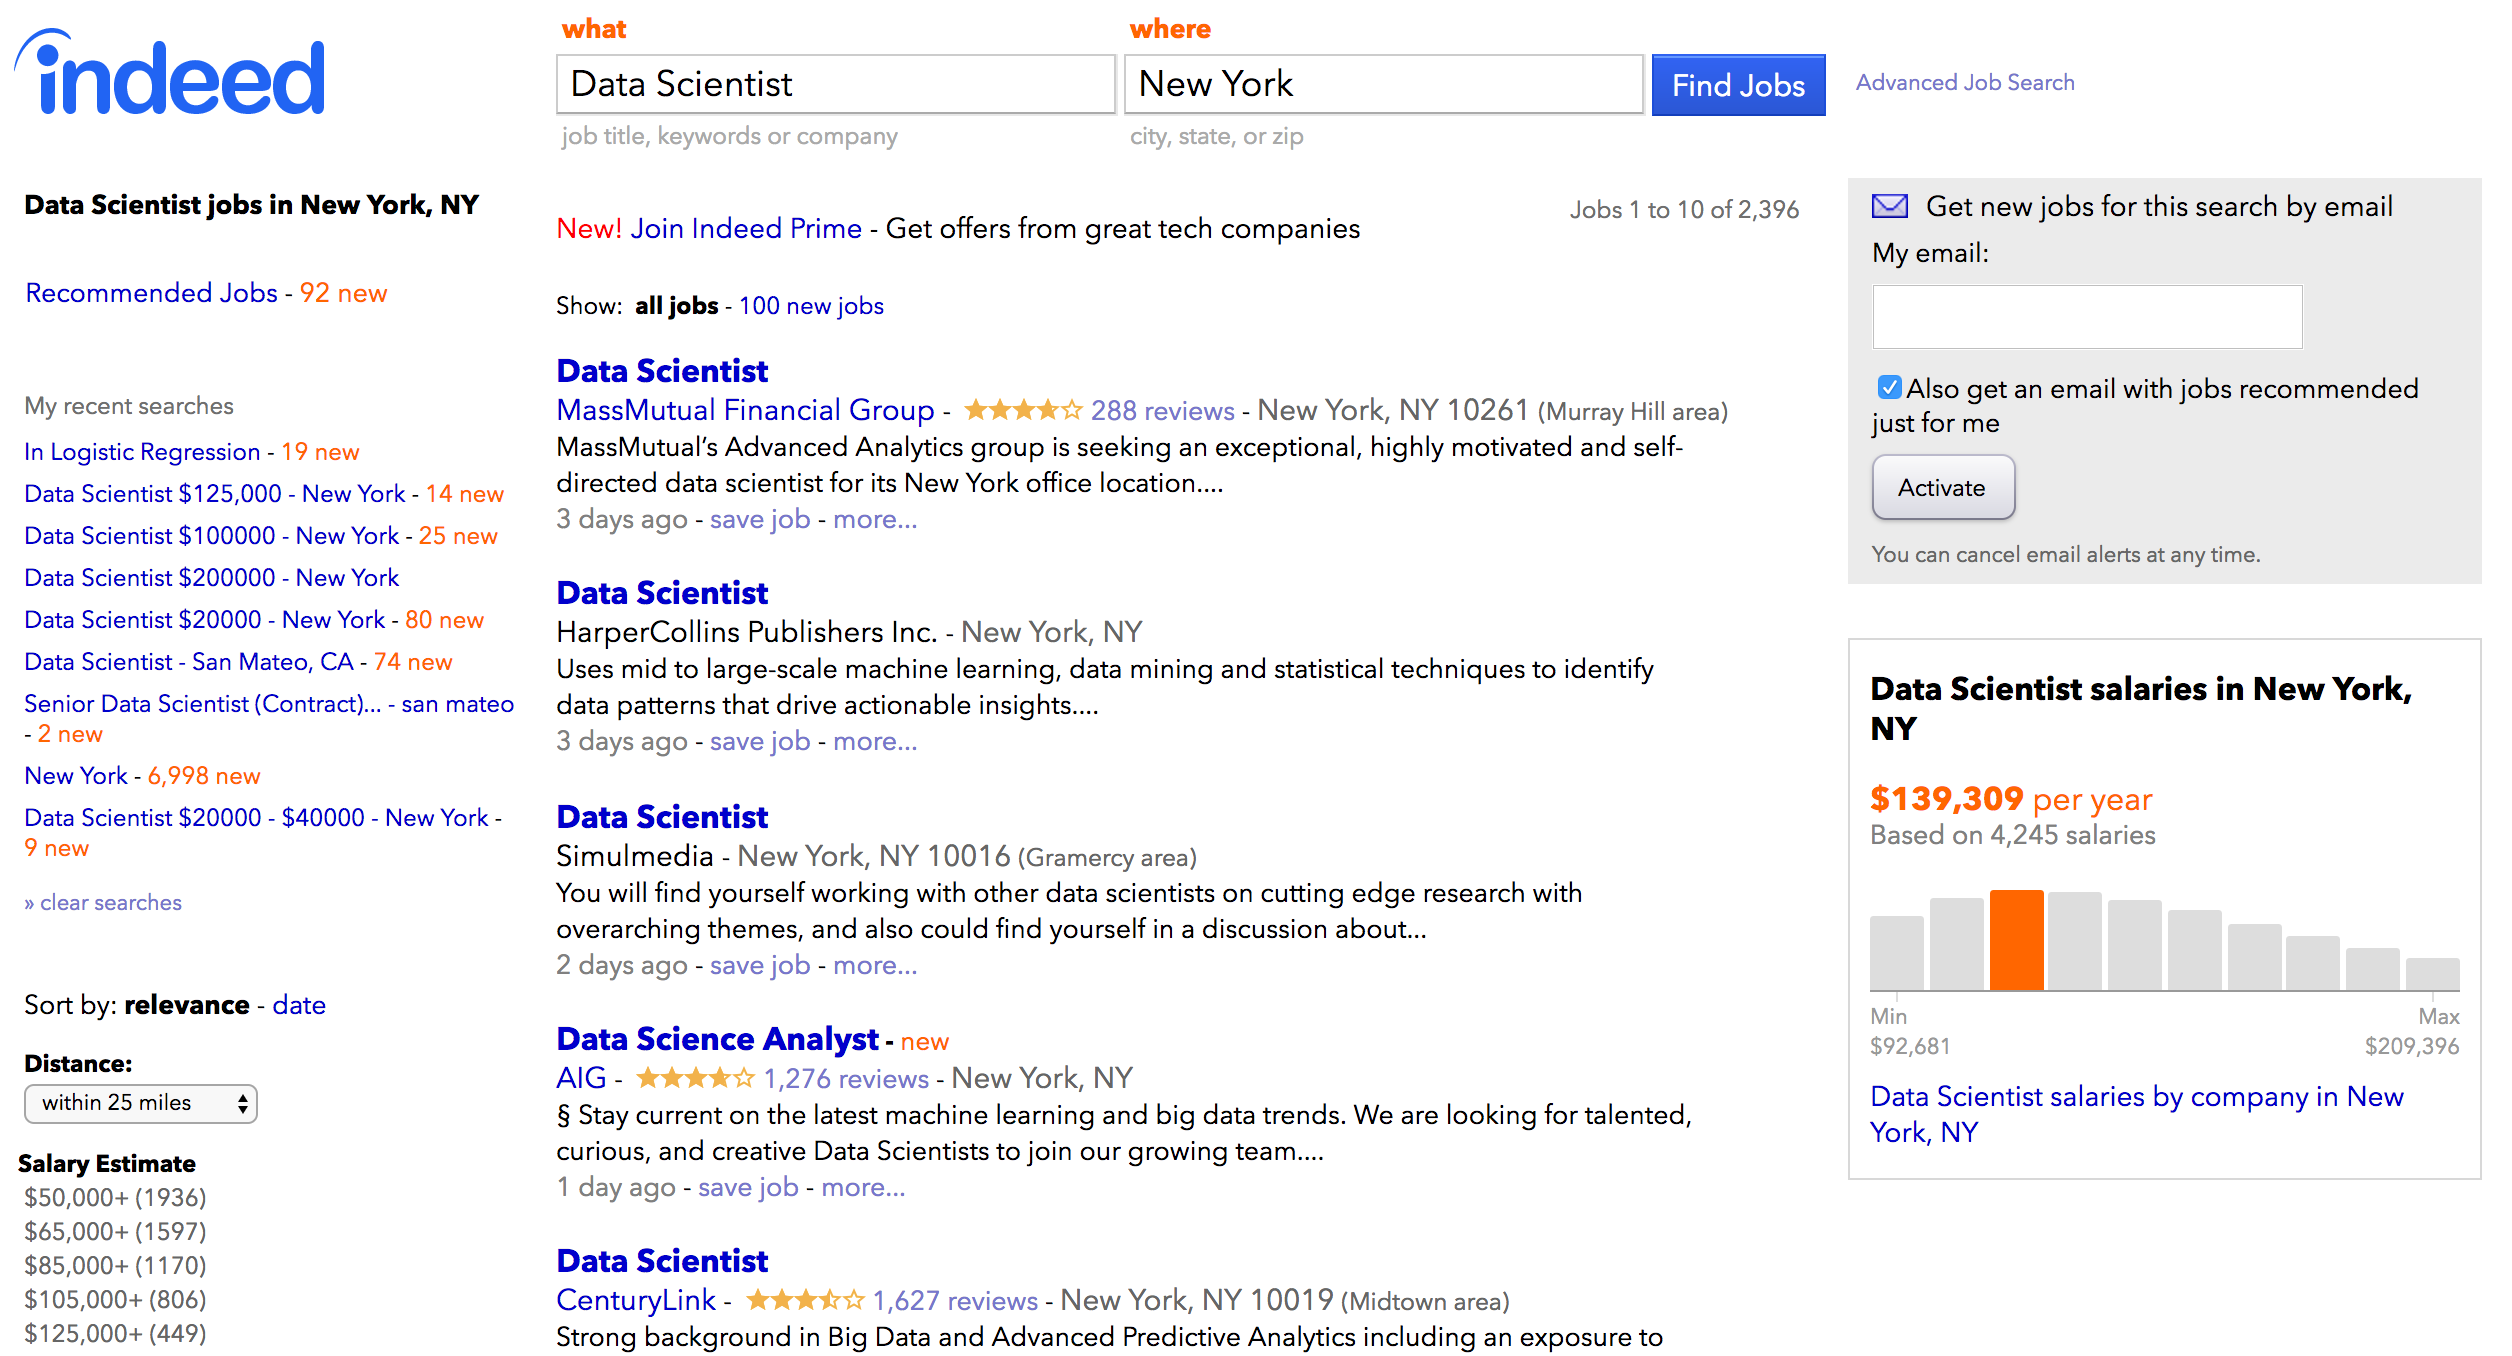

In [698]:
from IPython.display import Image
Image(filename='indeeed.png') 

In [699]:
df.shape

(5709, 6)

In [700]:
print "The Baseline Accuracy with our expanded data is:", round((4537./5709)*100,2), "% (When including Modal Group)"

The Baseline Accuracy with our expanded data is: 79.47 % (When including Modal Group)


We will create the target again for our full dataset:


In [701]:
median = np.median(df.salary)

In [702]:
df.loc[:,'hl'] = np.where(df.loc[:,'salary'] >= median, 1, 0)

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


Before we create our new variables, let's see what are the most common strings in the titles so that we can pick from them:

In [704]:
commontitle = coll.Counter(" ".join(df.title).split()).most_common(200)

In [705]:
print commontitle

[('data', 1423), ('scientist', 1370), ('-', 980), ('research', 846), ('senior', 803), ('engineer', 737), ('analyst', 709), ('manager', 389), ('software', 372), ('learning', 264), ('machine', 262), ('associate', 238), ('&', 234), ('sr.', 233), ('and', 227), ('scientist,', 222), ('analytics', 217), ('product', 195), ('science', 185), ('development', 176), ('manager,', 167), ('quantitative', 164), ('of', 156), ('clinical', 151), ('specialist', 149), ('/', 149), ('principal', 148), ('lead', 142), ('director', 138), ('statistical', 132), ('developer', 126), ('ii', 110), ('director,', 103), ('intern', 102), ('business', 102), ('i', 102), ('systems', 100), ('project', 97), ('marketing', 95), ('operations', 93), ('sr', 93), ('statistician', 86), ('engineering', 82), ('analyst,', 79), ('job', 79), ('engineer,', 77), ('staff', 74), ('analysis', 73), ('market', 68), ('management', 68), ('big', 65), ('programmer', 65), ('assistant', 63), ('program', 63), ('architect', 62), ('bioinformatics', 61), 

I will first make a list of a some features I believe are better predictors of higher paying jobs:

In [706]:
HighFeatures = [
    "senior",
    "sr",
    "specialist",
    "manager",
    "director",
    "fintech",
    "financial",
    "chief",
    "machine",
    "business",
    "principal",
    "natural",
    "cognitive",
    "equity",
    "quant",
    "finance",
    "corporate"
]

In [707]:
for x in HighFeatures:
    df[x] = np.where(df['title'].str.contains(x), 1, 0)

I will almost make a list of features in the title I believe are predictors of low paying jobs.

In [708]:
LowFeatures = [
    "intern",
    "part",
    "junior",
    "jr",
    "graduate",
    "post",
    "part"
]

In [709]:
for x in LowFeatures:
    df[x] = np.where(df['title'].str.contains(x), 1, 0)

In [710]:
df.head()

,title,company,salary,salrange,state,city,hl,senior,sr,specialist,...,equity,quant,finance,corporate,intern,part,junior,jr,graduate,post
0,ultimate hoops statistician,Life Time Fitness,40000,40000,TX,Sugar Land,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,research scientist,Houston Methodist,40000,40000,TX,Houston,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,research scientist,Preferred Sands,40000,40000,TX,Houston,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,quality assurance analyst (research),Baylor College of Medicine,43794,40000,TX,Houston,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,scientist,Houston Methodist,40000,40000,TX,Houston,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will create a copy of our df to use for modelling.

In [487]:
dfc = df

In [488]:
y = dfc.hl

In [494]:
y.shape

(5709,)

In [489]:
dfc.drop('hl', axis=1, inplace=True)

In [492]:
X = dfc

In [493]:
X.shape

(5709, 29)

We will split our data into a train and test split:

In [563]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [564]:
X_train.shape

(3825, 29)

In [565]:
X_test.shape

(1884, 29)

In [566]:
y_train.shape

(3825,)

In [567]:
y_test.shape

(1884,)

Let's first test our logistic regression model against our original with only state data, which wasn't very effective in predicting whether a salary was high or not. 

In [568]:
formula = '~ C(state) -1'

In [569]:
X_state_tr = patsy.dmatrix(formula, data=X_train, return_type='dataframe')
X_state_te = patsy.dmatrix(formula, data=X_test, return_type='dataframe')

In [570]:
logreg = LogisticRegression()
model = logreg.fit(X_state_tr, y_train)

In [574]:
model.score(X_state_tr, y_train)

0.79477124183006531

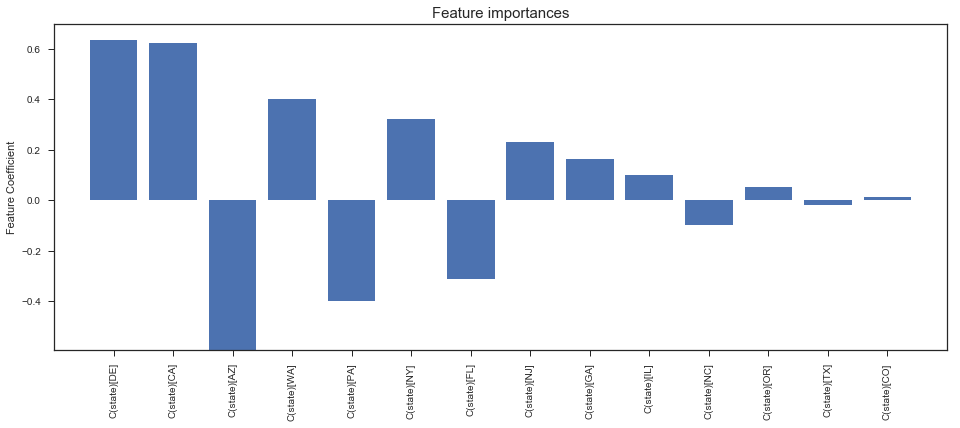

In [571]:
importances = model.coef_ # feature importance
indices = np.argsort(np.absolute(importances))# sort importance

# Plot the feature importances
plt.figure(figsize = (16, 6))
plt.title("Feature importances", fontsize = 15)
plt.bar(range(X_state_tr.shape[1]), importances[0][indices][0][::-1], align="center")
plt.ylabel('Feature Coefficient')
plt.xticks(range(X_state_tr.shape[1]), X_state_tr.columns[indices][0][::-1], rotation=90)
plt.xlim([-1, X_state_tr.shape[1]])
plt.show()

Our coefficients are much more smaller when we use a larger training set and this corresponds more to my assumptions that California and New York would be the biggest hubs for data scientists in the US and states like Arizona and Florida will be much more like to pay less to data scientists.

In [318]:
# Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

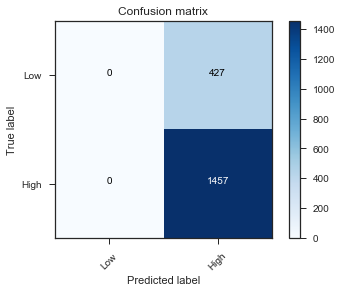

In [510]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, model.predict(X_state_te) )
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

We still see the same with our larger data, state is not a good predictor of high or low salaries, it is no better than our baseline model.

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


Whilst the coefficients are much smaller and normal, state is not a good predictor of whether a salary is high or not, our model almost fully predicts all high and it is the same as our baseline. Let's try adding the high and low features as well as city and see if it makes a difference.

In [578]:
def create_formula(features):    
    return " ~ " + " + ".join(features) + " + " + "-1"

In [579]:
nlist = HighFeatures+LowFeatures

In [599]:
create_formula(nlist)

' ~ senior + sr + specialist + manager + director + fintech + financial + chief + machine + business + principal + natural + cognitive + equity + quant + finance + corporate + -1'

In [605]:
formula = ' ~ C(state)  + senior + sr + specialist + manager + director + fintech + financial + chief + machine + business + principal + natural + cognitive + equity + quant + finance + corporate + intern + part + junior + jr + graduate + post + part -1'

In [606]:
X_ft_tr = patsy.dmatrix(formula, data=X_train, return_type="dataframe")
X_ft_te = patsy.dmatrix(formula, data=X_test, return_type="dataframe")

In [607]:
logreg = LogisticRegression()
model = logreg.fit(X_ft_tr, y_train)

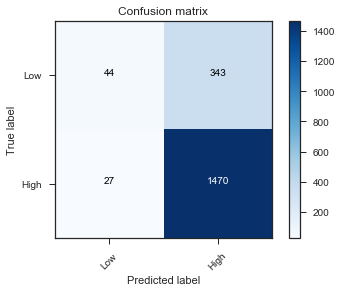

In [608]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, model.predict(X_ft_te) )
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

In [609]:
model.score(X_ft_tr, y_train)

0.79973856209150329

In [598]:
for f, c in zip(X_ft_tr.columns, model.coef_[0]):
     print f, c

C(state)[AZ] -0.474726579207
C(state)[CA] 0.600791484374
C(state)[CO] 0.0591612566315
C(state)[DE] 0.559090516229
C(state)[FL] -0.393762355576
C(state)[GA] 0.123758547879
C(state)[IL] 0.106420407057
C(state)[NC] -0.124941281197
C(state)[NJ] 0.100433111606
C(state)[NY] 0.239921940688
C(state)[OR] 0.197308690087
C(state)[PA] -0.437773297823
C(state)[TX] 0.036287037202
C(state)[WA] 0.327683309684
senior 1.16232383371
sr 0.849666739812
specialist -0.851630965354
manager 0.576308896684
director 1.30647705033
fintech 0.303450940947
financial 0.185538501205
chief 0.775245596247
machine 1.15716181792
business 0.261206695424
principal 1.34878547726
natural 0.863151493057
cognitive 0.160517638815
equity 0.437324732837
quant 0.868232316799
finance 1.16876383034
corporate 0.149718445517
intern -1.41099507805
part 0.010794341791
junior -1.00794113801
jr 0.4435076022
graduate -0.212612492163
post -1.24940519196


We only see a slight improvement in our model adding these features we still see a lot of false high salaries predicted, it seems with our imputed data it is much harder to predict a low paying salary than it is to predict a high paying salary. A job title with director out of our coefficients has the highest chance of being a high paying salary whereas a title with intern is the largest negative coefficient and predictor of low salaries.

Let's try adding cities and companies:

In [778]:
formula = 'hl ~ C(state) + C(company) + C(city) + senior + sr + specialist + manager + director + fintech + financial + chief + machine + business + principal + natural + cognitive + equity + quant + finance + corporate -1'

In [779]:
y_all,X_all = patsy.dmatrices(formula, data=df, return_type="dataframe")

In [780]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.33, random_state=42, stratify=y_all)

In [781]:
logreg = LogisticRegression()
model = logreg.fit(X_train_all, y_train_all)

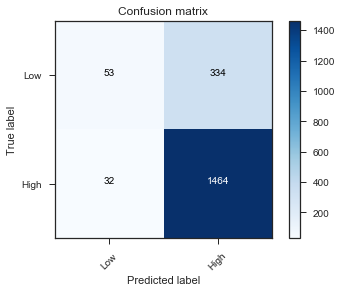

In [782]:
# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test_all, model.predict(X_test_all) )
plot_confusion_matrix(cnf_matrix, classes= ['Low', 'High'])

In [783]:
model.score(X_train_all, y_train_all)

0.83703897462725607

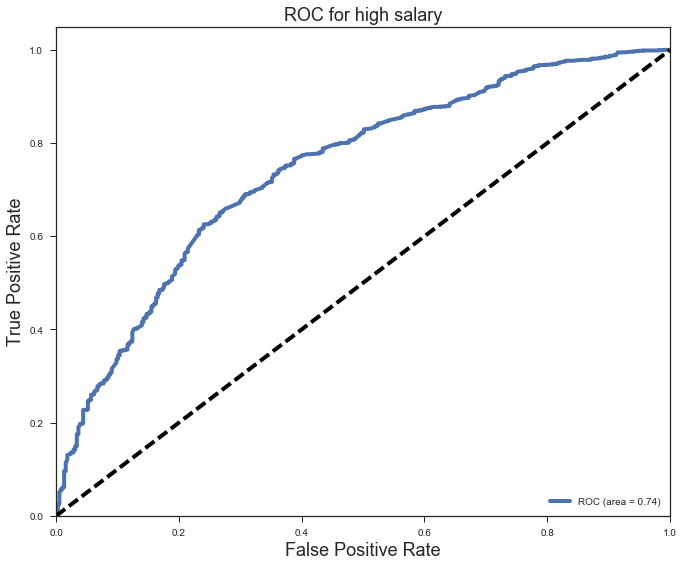

In [784]:
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for high salary', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')

Y_score = model.decision_function(X_test_all)
plot_roc(y_test_all, Y_score)

In [785]:
# for f, c in zip(X_train_all.columns, model.coef_[0]):
#      print f, c
#Ran and commented out for visibility, too many coefficients:

Our top coefficients correspond to the list that I generated but has not provided much scope for predicting a low salary.

senior 0.971123156303
sr 0.976693391139
specialist 0.982190574921
manager 0.990573842696
director 0.99920419058
fintech 1.00645756463
financial 1.04214380447
chief 1.08310568837
machine 1.1137879769
business 1.18092240923
principal 1.1826145776
natural 1.18865733037
cognitive 1.20121129337
equity 1.23697492088
quant 1.30922067361
finance 1.39649408028
corporate 1.45752460363

Our model improves only slightly over our baseline but we still have a lot of false high predictions.

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

We will test with different penalties, ridge vs lasso, when running a logistic regression model with penalties you need to standardize the features before running as we will end up with a set of coefficients that are proportional to each other.

In [786]:
ss = StandardScaler()
Xs = ss.fit_transform(X_train_all)

In [815]:
Xs_test = ss.fit_transform(X_test_all)

In [791]:
logregcv = LogisticRegressionCV(penalty = 'l1', cv =5, solver = 'liblinear')
model = logregcv.fit(Xs, y_train_all)

In [832]:
np.mean(model.scores_.values()[0].mean(axis=0))

0.65992519590733323

In [859]:
print classification_report(y_test_all, model.predict(Xs_test))

             precision    recall  f1-score   support

        0.0       0.57      0.13      0.22       387
        1.0       0.81      0.97      0.89      1496

avg / total       0.76      0.80      0.75      1883



In [850]:
coefs = zip(X_train_all.columns, model.coef_[0])
coefdf = pd.DataFrame(coefs, columns=['feature', 'coef'])

Our largest positive coefficients remain mostly the high features that we predicted with a few of the bigger cities for data science getting larger coefficients, like San Francisco and New York.

In [853]:
coefdf.sort_values(by='coef', ascending=False).head(10)

,feature,coef
1517,senior,0.324060
1451,C(city)[T.San Francisco],0.214614
1521,director,0.181808
1518,sr,0.169922
1527,principal,0.139678
1525,machine,0.115186
1520,manager,0.087470
1455,C(city)[T.San Mateo],0.077188
1395,C(city)[T.New York],0.067469
1241,C(city)[T.Bellevue],0.050860


In [854]:
coefdf.sort_values(by='coef', ascending=False).tail(10)

,feature,coef
766,C(company)[T.Northwestern University],-0.105348
11,C(state)[PA],-0.105484
1121,C(company)[T.University of California San Fran...,-0.109474
1519,specialist,-0.114897
744,C(company)[T.New York Institute of Technology],-0.115119
724,C(company)[T.NYU School of Medicine],-0.115781
1123,C(company)[T.University of Chicago],-0.117302
1135,C(company)[T.University of Washington Medical ...,-0.130908
487,C(company)[T.Guidepoint Global],-0.131493
1128,C(company)[T.University of Miami],-0.156347


We find that we have an abundance of negative coefficients for universities which could mean we are getting non data science jobs in our data that could be skewing, i.e. universities do have a lot of data related jobs but we see a lot of overlap with "research" jobs that may or may not be data scientist related roles.

In [799]:
logregcvl2 = LogisticRegressionCV(penalty = 'l2', cv =5, solver = 'liblinear')
modell2 = logregcvl2.fit(Xs, y_train_all)

In [833]:
np.mean(modell2.scores_.values()[0].mean(axis=0))

0.74079694076583524

In [860]:
print classification_report(y_test_all, modell2.predict(Xs_test))

             precision    recall  f1-score   support

        0.0       0.48      0.24      0.32       387
        1.0       0.83      0.93      0.88      1496

avg / total       0.75      0.79      0.76      1883



The score improves with ridge but is still lower than our baseline and not a good predictor of a high salary vs. our baseline. 

In [855]:
coefsl2 = zip(X_train_all.columns, modell2.coef_[0])
coefdfl2 = pd.DataFrame(coefsl2, columns=['feature', 'coef'])

In [856]:
coefdfl2.sort_values(by='coef', ascending=False).head(10)

,feature,coef
1334,C(city)[T.Hillsboro],0.977715
1455,C(city)[T.San Mateo],0.869420
1301,C(city)[T.Englewood],0.726942
1449,C(city)[T.San Bruno],0.708899
1532,finance,0.633512
1346,C(city)[T.Jersey City],0.586848
1489,C(city)[T.Vancouver],0.572662
1265,C(city)[T.Cary],0.566894
751,C(company)[T.Nielsen],0.564469
1272,C(city)[T.Chicago],0.559080


In our ridge regression the coefficients seem to favor certain smaller cities, a look below at one will show that these are hubs for data scientist roles with high paying jobs and tend to be at least in our modal group for salaries. A data scientist role in either of the two top cities will tend to be high paying, even more so than our expected of New York or San Francisco for example, just due to the overall salaries being high and the larger cities displaying more diversity in salaries.

In [870]:
df.loc[df.city == 'Hillsboro',['title','salary']]

,title,salary
1136,"artificial intelligence, machine learning deve...",40000
3238,statistician,80000
3241,2017 research scientist,80000
3244,statistical analyst,80000
3247,vice president of data science/machine learning,80000
3248,undergraduate intern- machine learning algorithms,80000
3252,sr. application scientist (oregon),80000
3255,d2i development initiator/development coordinator,80000
3256,_community manager - iii,80000
5199,hpc research scientist -- runtimes and automat...,120000


In [871]:
df.loc[df.city == 'San Mateo',['title','salary']]

,title,salary
236,data scientist,40000
262,software engineer - machine learning / predict...,40000
1490,analytics intern,80000
1508,"manager, statistical programmer",80000
1588,product manager,80000
1593,software engineer,80000
1597,process scientist,80000
1605,planning and research analyst (hsi-grant funded),97116
1620,senior data engineer (janusgraph),80000
1639,scientific analyst,80000


In [857]:
coefdf.sort_values(by='coef', ascending=False).tail(10)

,feature,coef
766,C(company)[T.Northwestern University],-0.105348
11,C(state)[PA],-0.105484
1121,C(company)[T.University of California San Fran...,-0.109474
1519,specialist,-0.114897
744,C(company)[T.New York Institute of Technology],-0.115119
724,C(company)[T.NYU School of Medicine],-0.115781
1123,C(company)[T.University of Chicago],-0.117302
1135,C(company)[T.University of Washington Medical ...,-0.130908
487,C(company)[T.Guidepoint Global],-0.131493
1128,C(company)[T.University of Miami],-0.156347


Again we see that universities tend to be negatively correlated to high paying jobs.